In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 49.0 MB/s eta 0:00:00


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/Bert/spam.csv')
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [5]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [6]:
df_spam = df[df['Category'] == 'spam']
df_ham = df[df['Category'] == 'ham']

In [7]:
print(df_spam.shape)
print(df_ham.shape)

(747, 2)
(4825, 2)


In [8]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [9]:
df_balanced = pd.concat([df_spam, df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [10]:
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [11]:
df_balanced.sample(5)

,Category,Message
1695,ham,Ü eatin later but i'm eatin wif my frens now l...
4914,spam,"Goal! Arsenal 4 (Henry, 7 v Liverpool 2 Henry ..."
4931,spam,"Hi, the SEXYCHAT girls are waiting for you to ..."
2863,spam,Adult 18 Content Your video will be with you s...
2904,ham,Tell me pa. How is pain de.


In [12]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x == 'spam' else 0)

In [13]:
df_balanced.sample(5)

,Category,Message,spam
1762,ham,Got ur mail Dileep.thank you so muchand look f...,0
3201,ham,Just curious because my cuz asked what I was u...,0
823,spam,"SMSSERVICES. for yourinclusive text credits, p...",1
3725,spam,"Hi there, 2nights ur lucky night! Uve been inv...",1
4157,ham,"Yo, call me when you get the chance, a friend ...",0


In [14]:
from re import X
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify= df_balanced['spam'])

In [15]:
X_train.head()
y_train.head()

4683    0
3382    1
910     1
4158    0
3565    0
Name: spam, dtype: int64

In [16]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [17]:
def get_sentence_embedding(X_train):
  preprocesssed = bert_preprocess(X_train)
  bert_outputs = bert_encoder(preprocesssed)
  return bert_outputs['pooled_output']


In [22]:
e = get_sentence_embedding([
    'banana',
    'apple',
    'orange',
    'pineapple',
    'mango',
    'airplane',
    'car',
    'truck',
    'boat',
    'train'
])

In [23]:
from  sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([e[0]], [e[7]])

array([[0.9838934]], dtype=float32)

In [24]:
e

<tf.Tensor: shape=(10, 768), dtype=float32, numpy=
array([[-0.7606917 , -0.1421939 ,  0.4960469 , ...,  0.42165375,
        -0.532214  ,  0.80312157],
       [-0.81964576, -0.2960963 ,  0.2095164 , ...,  0.255933  ,
        -0.58743   ,  0.8434557 ],
       [-0.8363078 , -0.23830129,  0.38453618, ...,  0.45564792,
        -0.6078617 ,  0.8278892 ],
       ...,
       [-0.8211139 , -0.16261372,  0.3010141 , ...,  0.3321837 ,
        -0.53959805,  0.85382956],
       [-0.8402    , -0.29704037,  0.15870014, ...,  0.17637555,
        -0.60028195,  0.85932255],
       [-0.7283893 , -0.05742337,  0.58349115, ...,  0.47267264,
        -0.5055893 ,  0.76955867]], dtype=float32)>

In [27]:
#bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_test_input = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_test_input)

#nn layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
hidden1 = tf.keras.layers.Dense(24, activation='relu', name="dense_1")(l)
hidden2 = tf.keras.layers.Dense(24, activation='relu', name="dense_2")(hidden1)
main_output = tf.keras.layers.Dense(1, activation='sigmoid', name="main_output")(hidden2)

#construct final model
model = tf.keras.Model(inputs=[text_input], outputs=[main_output])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [28]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [30]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 22s 315ms/step - loss: 0.6076 - accuracy: 0.6839 - precision: 0.6746 - recall: 0.7107
Epoch 2/10
35/35 [==============================] - 11s 324ms/step - loss: 0.3886 - accuracy: 0.8491 - precision: 0.8436 - recall: 0.8571
Epoch 3/10
35/35 [==============================] - 11s 311ms/step - loss: 0.3006 - accuracy: 0.8786 - precision: 0.8630 - recall: 0.9000
Epoch 4/10
35/35 [==============================] - 12s 330ms/step - loss: 0.2434 - accuracy: 0.9161 - precision: 0.9146 - recall: 0.9179
Epoch 5/10
35/35 [==============================] - 12s 331ms/step - loss: 0.2190 - accuracy: 0.9277 - precision: 0.9209 - recall: 0.9357
Epoch 6/10
35/35 [==============================] - 12s 340ms/step - loss: 0.2193 - accuracy: 0.9232 - precision: 0.9278 - recall: 0.9179
Epoch 7/10
35/35 [==============================] - 11s 327ms/step - loss: 0.2112 - accuracy: 0.9304 - precision: 0.9366 - recall: 0.9232
Epoch 8/10
35/35 [================

In [31]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 5s 330ms/step - loss: 0.1639 - accuracy: 0.9465 - precision: 0.9718 - recall: 0.9198


[0.163885235786438, 0.9465240836143494, 0.9717513918876648, 0.9197860956192017]

In [34]:
import numpy as np

y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()


y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

12/12 [==============================] - 3s 308ms/step


array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_predicted)
print(cm)
print(classification_report(y_test, y_predicted))

[[182   5]
 [ 15 172]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       187
           1       0.97      0.92      0.95       187

    accuracy                           0.95       374
   macro avg       0.95      0.95      0.95       374
weighted avg       0.95      0.95      0.95       374



Text(50.722222222222214, 0.5, 'Truth')

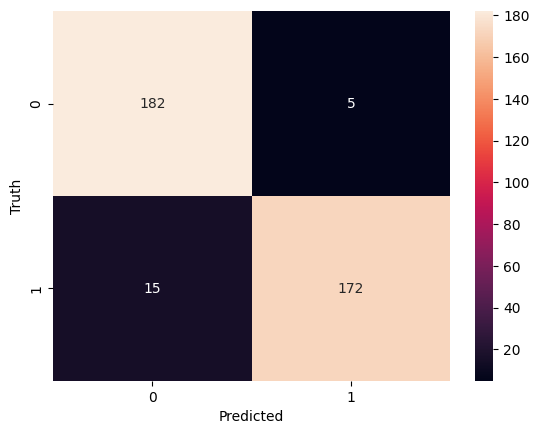

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')